In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset

from scipy.spatial.transform import Rotation as R

import semd2d_utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset = "data/esim_data/line_top/"
events = np.loadtxt(path + dataset + "events.txt")

In [3]:
# use only the specified patch of input events
patch_center = (90, 90)
patch_size = 180
events = semd2d_utils.filter_patch(events, patch_center, patch_size)

data_steps = 100 # timesteps to divide the data into
sim_steps = 100 # simulation steps
shape = (patch_size, patch_size)
t_start = events[0, 0]
duration = events[-1, 0] - events[0, 0]

In [4]:
events_conv, new_shape = flt.filter_conv(events, shape, factor=2)
shape = new_shape
events = events_conv

In [5]:
events = flt.filter_refract(events, 0.2)
events = flt.filter_time(events, 2.5, 2.6)

In [6]:
t_start = events[0, 0]
duration = events[-1, 0] - events[0, 0]

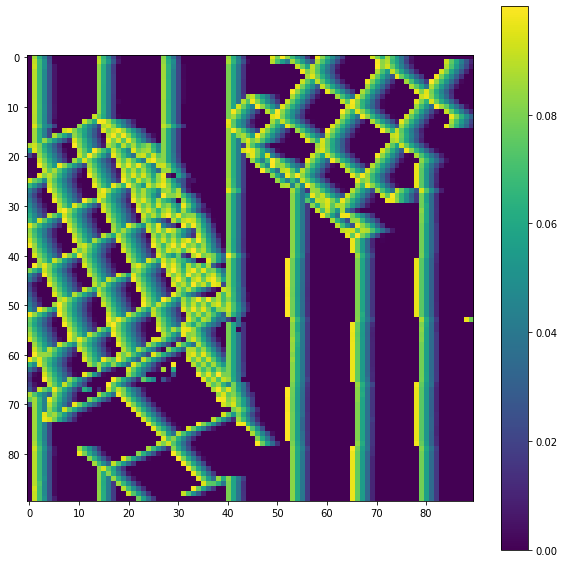

In [7]:
img = vis.events2time_surf(events[:], shape, filter_polarity=False)
plt.figure(figsize=(10, 10))
m = plt.imshow(img, interpolation="none")
plt.colorbar(m)

In [8]:
args = {
    "shape":shape,
    "conv_shape": (1,1),
    "conv_stride": (1,1),
    "thresh_conv": 0.5,
    "detector_du": 0.1,
    "tu": int(-186.19655666 / 2),
    "tv": 0
}
data_u, data_v, data_d = semd2d_utils.run_sim(args, events, data_steps, sim_steps)

MemoryError: Unable to allocate 501. MiB for an array with shape (8100, 8100) and data type float64

In [ ]:
# %matplotlib inline
# plt.figure(figsize=(10, 10))
# img = np.sum(data_u[:,:,0:], axis=-1)
# img_m = np.ma.masked_where(img==0, img)
# m = plt.imshow(img_m, cmap="jet")
# plt.colorbar(m)

In [ ]:
# data_m = np.ma.masked_where(data_u==0, data_u)
# plt.hist(data_m.compressed(), 100);

In [ ]:
data_u *= 0.01
data_v *= 0.01

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = np.sqrt(np.square(data_u) + np.square(data_v)).sum(axis=-1)
plt.quiver(data_u.sum(axis=-1), data_v.sum(axis=-1), m, cmap="jet_r")
plt.gca().invert_yaxis()

In [ ]:
plt.figure(figsize=(10, 10))
m_m = np.ma.masked_where(m==0.0, m)
plt.imshow(m_m, interpolation="none", cmap="jet_r")

In [ ]:
# med = flt.median_filter(m_m, 3)
# med_m = np.ma.masked_where(med==0.0, med)
# plt.figure(figsize=(10, 10))
# plt.imshow(med_m, interpolation="none", cmap="jet_r")

In [ ]:
d = data_u.sum(axis=-1) * (-53) + data_v.sum(axis=-1) * 0.0

In [ ]:
plt.figure(figsize=(10, 10))
d_m = np.ma.masked_where(d <= 0.0, d)
m = plt.imshow(d_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

In [ ]:
plt.hist(d_m.compressed(), 100);
plt.axvline(x=np.ma.mean(d_m), c="red", label="mean")
print(np.ma.mean(d_m))

In [ ]:
%matplotlib inline
t = 70
data_dn = np.divide(data_d[:,:,t:].sum(axis=-1), (data_d[:,:,t:] != 0.0).sum(axis=-1), where=(data_d[:,:,t:] != 0.0).sum(axis=-1)!=0.0)
plt.figure(figsize=(10, 10))
data_d_m = np.ma.masked_where(data_dn==0.0, data_dn) * (0.1 / sim_steps)
img_gray = plt.imread(path + dataset+ "images/frame_00000074.png")
plt.imshow(img_gray[::2, ::2], alpha=0.3, cmap="gray")
m = plt.imshow(data_d_m, interpolation="none", cmap="jet_r", vmax=3)
plt.colorbar(m)

In [ ]:
plt.hist(data_d_m.compressed(), 100);
plt.axvline(x=np.ma.mean(data_d_m), c="red", label="mean")
print(np.ma.mean(data_d_m))

In [ ]:
d = data_d_m

points = vis._image2pointcloud(d)
calib = np.loadtxt(path + dataset + "calib.txt") / 2
gt = np.loadtxt(path + dataset + "groundtruth.txt")
idx = np.searchsorted(gt[:, 0], t_start)
p = gt[idx]
#p[[1, 2]] = p[[2, 1]]
# print(p)

proj = td.project3d(points, calib, p)
proj = proj[np.any(np.logical_not(np.isinf(proj)), axis=1)]

proj = proj[proj[:,2] > -2]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3], cmap="jet", z=2)

o3d.visualization.draw_geometries([pcd])

In [ ]:
gt_depths = np.load(path + dataset + "/depths.npy")

%matplotlib inline
image_index = 72

gt_d = gt_depths[image_index,::2,:180:2]
gt_m = np.ma.masked_where(data_d_m == 0.0, gt_d)

m = plt.imshow(gt_m, cmap="jet_r", vmin=0, vmax=3, interpolation="none")
plt.colorbar(m)

In [ ]:
def measure_error(measured, gt):
    diff = np.abs(measured - gt)
    fig, axs = plt.subplots(2, figsize=(10, 10))
    axs[0].hist(diff.compressed(), 100, range=(0, 5));
    axs[0].axvline(x=np.ma.median(diff), c="red", label="mean")

    m = axs[1].imshow(diff, interpolation="none", cmap="plasma")
    plt.colorbar(m)

    median = np.ma.median(diff)
    mean = np.ma.mean(diff)
    
    print("median error: {}, mean error: {}".format(median, mean))

measure_error(data_d_m, gt_m)

In [ ]:
data_median = td2d.median_filter(data_d_m, 5)
m = plt.imshow(data_median, interpolation="none", cmap="jet_r")
plt.colorbar(m)

In [ ]:
measure_error(data_median, gt_m)

In [ ]:
data_mean = td2d.filter_depth(data_d_m, 300.0, 7)
m = plt.imshow(data_mean, interpolation="none", cmap="jet_r")
plt.colorbar(m)

In [ ]:
measure_error(data_mean, gt_m)